# Transformer Training

**Purpose.** This notebook trains the Transformer model used in the thesis.  
It produces a saved Keras model **`Models/transformer_model_scaled.keras`** and the paired scalers  
**`Models/transformer_x_scaler.pkl`**, **`Models/transformer_y_scaler.pkl`** used for evaluation.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/MSc/

Mounted at /content/drive
/content/drive/MyDrive/MSc


In [ ]:
# 1. Imports
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import MinMaxScaler
import joblib
import os
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
os.makedirs("saved_models", exist_ok=True)

In [ ]:
#  2. Load Synthetic Data
X = np.load("/content/drive/MyDrive/MSc/SyntheticData/X_jittery.npy")
y = np.load("/content/drive/MyDrive/MSc/SyntheticData/Y_smooth.npy")

print("Loaded synthetic data:")
print("X shape:", X.shape)
print("y shape:", y.shape)


Loaded synthetic data:
X shape: (500, 124, 3)
y shape: (500, 124, 3)


In [ ]:
# 3. Scale Data
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
X_reshaped = X.reshape(-1, 3)
y_reshaped = y.reshape(-1, 3)
scaler_x.fit(X_reshaped)
scaler_y.fit(y_reshaped)
X_scaled = np.array([scaler_x.transform(seq) for seq in X])
y_scaled = np.array([scaler_y.transform(seq) for seq in y])
joblib.dump(scaler_x, "saved_models/transformer_x_scaler.pkl")
joblib.dump(scaler_y, "saved_models/transformer_y_scaler.pkl")

['saved_models/transformer_y_scaler.pkl']

In [ ]:
#  4. Positional Encoding
def get_positional_encoding(seq_len, d_model):
    angle_rads = np.arange(seq_len)[:, np.newaxis] / np.power(
        10000, (2 * (np.arange(d_model)[np.newaxis, :] // 2)) / d_model)
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    return angle_rads[np.newaxis, ...]

In [ ]:
# 5. Build Transformer Model
def build_transformer(seq_len=124, d_model=64, heads=4, ff_dim=128):
    input_layer = layers.Input(shape=(seq_len, 3))
    pos_encoding = get_positional_encoding(seq_len, d_model)
    x = layers.Dense(d_model)(input_layer)
    x += tf.cast(pos_encoding, dtype=tf.float32)
    attn_output = layers.MultiHeadAttention(num_heads=heads, key_dim=d_model)(x, x)
    x = layers.Add()([x, attn_output])
    x = layers.LayerNormalization()(x)
    ff_output = layers.Dense(ff_dim, activation='relu')(x)
    ff_output = layers.Dense(3)(ff_output)
    model = models.Model(inputs=input_layer, outputs=ff_output)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model
transformer_model = build_transformer()

In [ ]:
# 6. Train Model
checkpoint = ModelCheckpoint(
    'saved_models/transformer_model_scaled.keras',
    save_best_only=True,
    monitor='val_loss',
    mode='min')
history = transformer_model.fit(
    X_scaled, y_scaled,
    validation_split=0.2,
    epochs=50,
    batch_size=2,
    callbacks=[checkpoint])

Epoch 1/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - loss: 0.0693 - mae: 0.1324 - val_loss: 0.0016 - val_mae: 0.0331
Epoch 2/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 8.4884e-04 - mae: 0.0232 - val_loss: 5.2379e-04 - val_mae: 0.0181
Epoch 3/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - loss: 6.3039e-04 - mae: 0.0199 - val_loss: 0.0017 - val_mae: 0.0354
Epoch 4/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 5.8949e-04 - mae: 0.0195 - val_loss: 3.3139e-04 - val_mae: 0.0146
Epoch 5/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 5.7915e-04 - mae: 0.0188 - val_loss: 7.8678e-04 - val_mae: 0.0246
Epoch 6/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 6.2038e-04 - mae: 0.0197 - val_loss: 4.5690e-04 - val_mae: 0.0179
Epoch 7/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 5.2034e-04 - mae: 0.0177 - val_loss: 7.2502e-04 - val_mae: 0.0221
Epoch 8/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 4.7309e-04 - mae: 0.0173 - val_loss: 3.0934e-04 - val_mae: 0.

In [ ]:
# 7. Save Training History
import pickle
with open("saved_models/transformer_training_history.pkl", "wb") as f:
    pickle.dump(history.history, f)

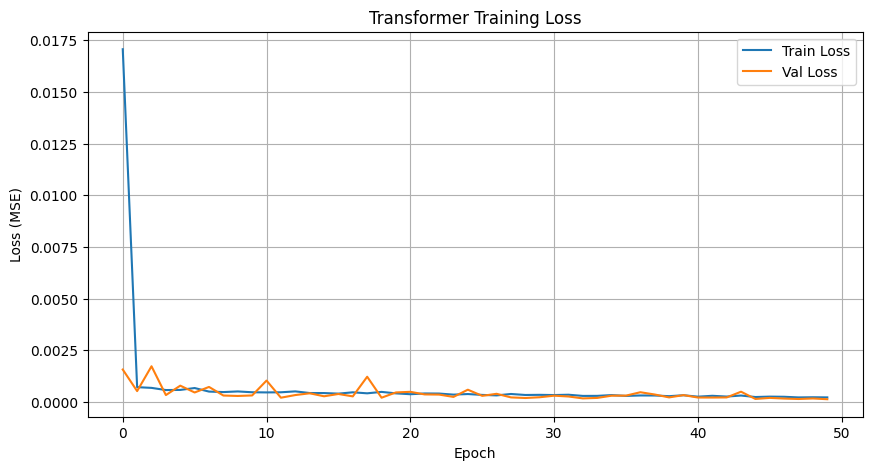

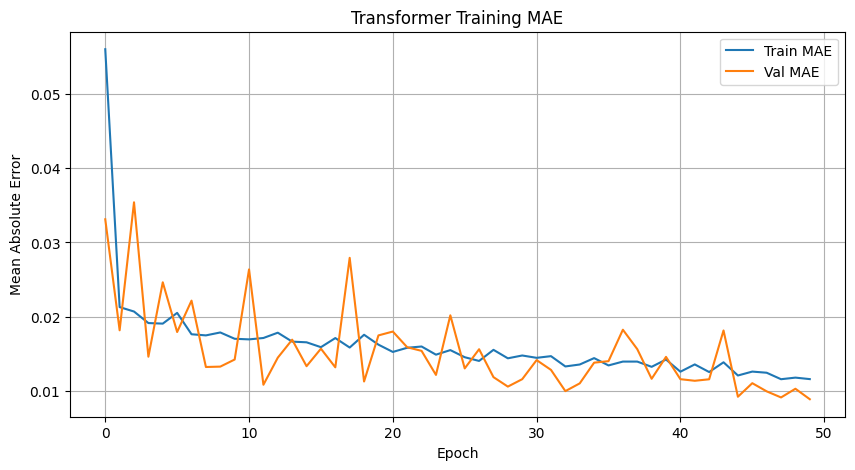

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Transformer Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

# Plot training & validation MAE
plt.figure(figsize=(10, 5))
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title('Transformer Training MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.grid(True)
plt.show()
